In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.1 MB/s eta 0:00:00


In [25]:
import random
import matplotlib.pyplot as plt
import time
import numpy as np
from deap import base, creator, tools

# Константы

In [111]:
BOARD_SIZE = 8 # Размер доски
POPULATION_SIZE = 300  # Размер популяции
GENERATIONS = 100 # Количество поколений
CROSSOVER_PROB = 0.5 # Вероятность кроссовера

# Создание класса Fitness и Individual

In [112]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Хранилище данных

In [113]:
GA_UASGE = {
    "mutate": 0,
    "crossover": 0
}

# Вспомогательные методы

In [114]:
def random_point():
    return random.randint(0, BOARD_SIZE-1), random.randint(0, BOARD_SIZE-1)

In [115]:
toolbox = base.Toolbox()
toolbox.register("random_point", random_point)

In [116]:
def generate_queen_placement():
    """Генерация случайной расстановки ферзей."""
    return [toolbox.random_point() for _ in range(BOARD_SIZE)]

# Мутация


In [117]:
def get_decay_coefficient(generation_number):
  return (generation_number * 1.0) / GENERATIONS


def inversion_mutation(individual):
  dimension = len(individual)

  from_idx, to_idx = toolbox.random_point()
  for i in range(from_idx, from_idx + (to_idx - from_idx + 1) // 2):
      individual[i], individual[to_idx - (i - from_idx)] = individual[to_idx - (i - from_idx)], individual[i]
  return individual


def random_mutation(individual):
  dimension = len(individual)
  index = random.randint(0, len(individual) - 1)
  individual[index] = toolbox.random_point()
  # individual[two_random_alleles[0]], individual[two_random_alleles[1]] = toolbox.random_point()
  return individual


def choose_mutation_strategy(generation_number):
  prob = random.uniform(0, 1)
  decay = get_decay_coefficient(generation_number)
  exploration_threshold = 1 - decay * decay
  if prob <= exploration_threshold:
      return inversion_mutation
  else:
      return random_mutation


def mutate(individual, generation_number):
  """Мутация"""
  mutation_strategy = choose_mutation_strategy(generation_number)
  mutation_strategy(individual)
  GA_UASGE["mutate"] += 1
  return individual



In [118]:
# def mutate(individual):
#     """Мутация"""
#     # Работает очень плохо
#     index = random.randint(0, len(individual) - 1)
#     individual[index] = toolbox.random_point()
#     return individual

# Кроссовер

1. Внутреннее кроссоверное смешивание (**order_crossover_internal**):

* Этап выполняет кроссовер между двумя родителями.
* Принимает на вход два родительских списка и определенный сегмент для * кроссовера.
* Создает нового потомка путем комбинации родительских генов в определенном * сегменте и заполнения остальных генов недостающими значениями из второго родителя.


2. Кроссовер (**order_crossover**):

*  Этап генерирует случайные индексы для определения сегмента кроссовера и вызывает функцию внутреннего кроссовера, чтобы выполнить операцию мутации.


3. Создание потомков (**mate**):

* Этап создает потомков путем выполнения кроссовера между двумя родителями и добавления их в список потомков.
* Подсчитывает количество выполненных кроссоверов.

In [119]:
# def crossover(ind1, ind2):
#     """Кроссовер"""
#     # Работает очень плохо
#     cxpoint = random.randint(0, len(ind1))
#     return ind1[:cxpoint] + ind2[cxpoint:], ind2[:cxpoint] + ind1[cxpoint:]

In [120]:
 def order_crossover_internal(base_parent, traverse_parent, a, b):
  """
  Выполняет внутреннее кроссоверное смешивание между двумя родителями.

  :param base_parent: Список, представляющий первого родителя.
  :param traverse_parent: Список, представляющий второго родителя.
  :param a: Индекс, указывающий начало сегмента кроссовера.
  :param b: Индекс, указывающий конец сегмента кроссовера.
  :return: Список, представляющий потомка после кроссовера.
  """
  dimension = len(base_parent)
  child = [0] * dimension
  used = set()
  for i in range(a, b + 1):
      cur = base_parent[i]
      used.add(cur)
      child[i] = cur
  insert_index = (b + 1) % dimension
  for i in range(dimension):
      cur_index = (b + 1 + i) % dimension
      cur = traverse_parent[cur_index]
      if cur not in used:
          child[insert_index] = cur
          insert_index = (insert_index + 1) % dimension


 def order_crossover(p1, p2):
  """
  Выполняет кроссовер между двумя родителями.

  :param p1: Список, представляющий первого родителя.
  :param p2: Список, представляющий второго родителя.
  :return: Список, представляющий потомка после кроссовера.
  """
  individual1 = p1
  individual2 = p2
  assert len(individual1) == len(individual2)
  dimension = len(individual1)
  two_random_alleles = toolbox.random_point()

  a, b = two_random_alleles
  child = order_crossover_internal(individual1, individual2, a, b)

  return child


 def mate(p1, p2):
    """
    Создает потомков из двух родительских особей с использованием кроссовера по порядку.

    :param p1: Список, представляющий первого родителя.
    :param p2: Список, представляющий второго родителя.
    :return: Список, содержащий двух потомков после кроссовера.
    """
    children = []
    children.append(order_crossover(p1, p2))
    children.append(order_crossover(p2, p1))
    GA_UASGE["crossover"] += 1
    return children

# Фитнес фанк

Эта фитнес-функция предназначена для оценки качества расстановки ферзей на шахматной доске. Основная задача функции - определить количество пар ферзей, которые могут атаковать друг друга.

Процесс работы функции следующий:

1. Перебираются все возможные пары ферзей на доске.
2. Для каждой пары ферзей проверяется, находятся ли они в атакующем положении. Пара ферзей находится в атакующем положении, если они расположены на одной вертикали, горизонтали или диагонали.
3. Если пара ферзей находится в атакующем положении, количество конфликтов увеличивается на 1.
4. Возвращается кортеж, содержащий количество конфликтов. Это количество является мерой качества текущей расстановки ферзей: чем меньше конфликтов, тем лучше расположение ферзей на доске.

In [121]:
def get_fitness(individual):
    """Функция оценки: число конфликтов - количество атакующих пар."""
    conflicts = 0
    for i in range(len(individual)):
        for j in range(i + 1, len(individual)):
            x1, y1 = individual[i][0], individual[i][1]
            x2, y2 = individual[j][0], individual[j][1]
            if x1 == x2 or y1 == y2 or abs(x1 - x2) == abs(y1 - y2):
                conflicts += 1
    return (conflicts,)

# Определение всех основных действий


Алгоритм работает до достижение определенного значения целевой функции. Алгоритм останавливается, когда значение целевой функции достигает значения 0.

In [122]:
toolbox.register("queen_placement", generate_queen_placement)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.queen_placement)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("fitness", get_fitness)
toolbox.register("mate", mate)
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

In [123]:
def evolution_algo(verbose: bool = False):
    GA_UASGE['mutate'] = 0
    GA_UASGE['crossover'] = 0

    # Создание начальной популяции
    population = toolbox.population(n=POPULATION_SIZE)


    # Оценка популяции
    fitnesses = list(map(toolbox.fitness, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # for generation in range(1, GENERATIONS + 1):
    start_time = time.time()
    generation = 1
    while True:
        print(f"--- Поколение {generation} ---") if verbose else None

        # Выбор следующего поколения
        offspring = toolbox.select(population, len(population))

        # Клонирование выбранных особей
        offspring = list(map(toolbox.clone, offspring))

        # Применение кроссовера и мутации
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CROSSOVER_PROB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            toolbox.mutate(mutant, generation)
            del mutant.fitness.values

        # Оценка потомков с невалидными оценками
        invalid_individuals = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.fitness, invalid_individuals)
        for ind, fit in zip(invalid_individuals, fitnesses):
            ind.fitness.values = fit

        # Замена текущей популяции потомками
        population[:] = offspring

        # Вывод лучшего решения текущего поколения
        best_individual = tools.selBest(population, 1)[0]
        print(f"Лучшее решение: {best_individual}, Конфликты: {best_individual.fitness.values[0]}") if verbose else None

        if best_individual.fitness.values[0] == 0:
            end_time = time.time() - start_time
            break
        generation += 1

    print("--- Окончательное решение ---")
    print(f"Лучшее решение: {best_individual}, Конфликты: {best_individual.fitness.values[0]}")
    return best_individual, end_time, generation

In [124]:
def draw_chessboard(points):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if (i + j) % 2 == 0:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='white'))
            else:
                ax.add_patch(plt.Rectangle((i, j), 1, 1, color='black'))
    for point in points:
        x, y = point
        ax.plot(x + 0.5, y + 0.5, 'ro')

    ax.set_xlim(0, BOARD_SIZE)
    ax.set_ylim(0, BOARD_SIZE)

    ax.set_aspect('equal')

    plt.gca().invert_yaxis()
    plt.show()


def plot_bar_chart(data_dict):
    categories = list(data_dict.keys())
    heights = list(data_dict.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, heights)
    plt.xlabel("Тип оператора")
    plt.ylabel("Кол-во применений")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Inference

--- Окончательное решение ---
Лучшее решение: [(6, 2), (2, 7), (5, 0), (3, 1), (7, 4), (4, 6), (0, 3), (1, 5)], Конфликты: 0.0


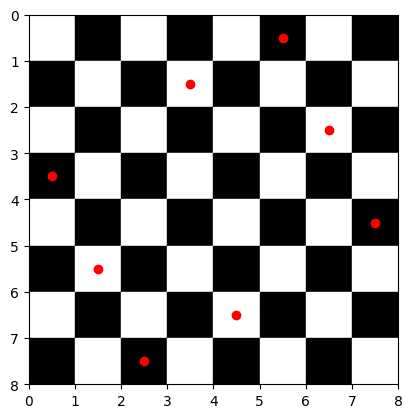

--- Окончательное решение ---
Лучшее решение: [(1, 0), (3, 3), (5, 6), (7, 5), (0, 4), (4, 1), (2, 7), (6, 2)], Конфликты: 0.0


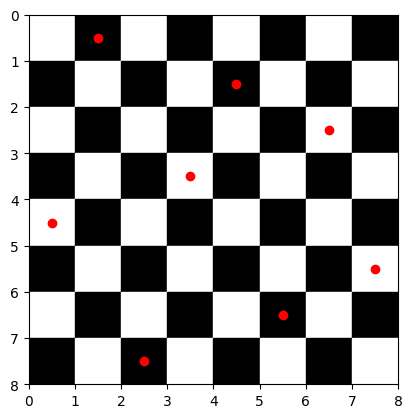

--- Окончательное решение ---
Лучшее решение: [(5, 3), (4, 0), (0, 2), (2, 1), (7, 4), (6, 7), (1, 5), (3, 6)], Конфликты: 0.0


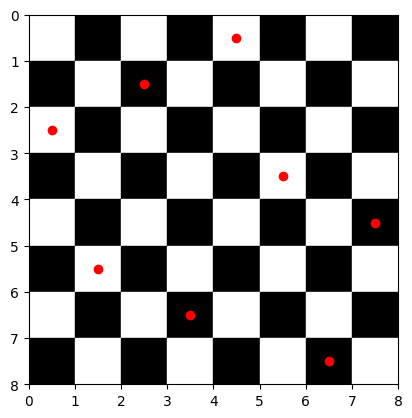

--- Окончательное решение ---
Лучшее решение: [(1, 5), (4, 0), (0, 1), (6, 6), (3, 2), (2, 7), (5, 3), (7, 4)], Конфликты: 0.0


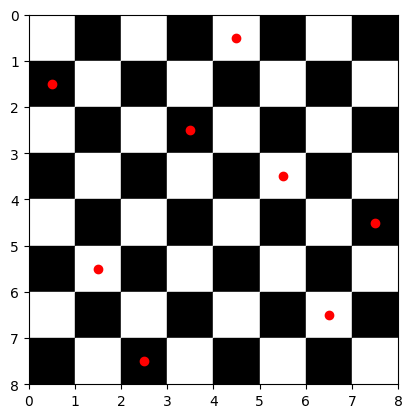

--- Окончательное решение ---
Лучшее решение: [(6, 4), (1, 5), (2, 7), (0, 3), (7, 1), (3, 2), (5, 6), (4, 0)], Конфликты: 0.0


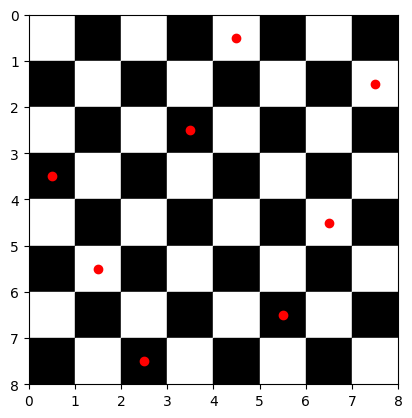

--- Окончательное решение ---
Лучшее решение: [(2, 7), (5, 2), (1, 1), (0, 3), (6, 4), (4, 0), (3, 5), (7, 6)], Конфликты: 0.0


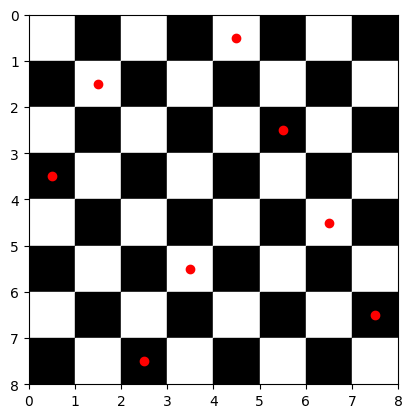

--- Окончательное решение ---
Лучшее решение: [(7, 7), (6, 1), (4, 2), (5, 4), (2, 6), (0, 5), (3, 0), (1, 3)], Конфликты: 0.0


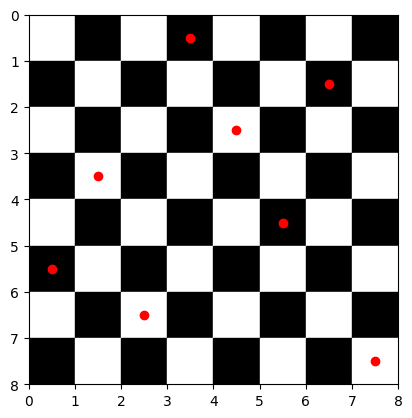

--- Окончательное решение ---
Лучшее решение: [(4, 7), (0, 4), (5, 5), (3, 2), (2, 0), (1, 6), (6, 3), (7, 1)], Конфликты: 0.0


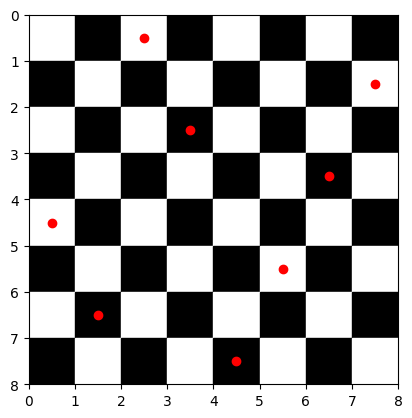

--- Окончательное решение ---
Лучшее решение: [(4, 0), (6, 7), (5, 5), (2, 4), (0, 3), (3, 2), (7, 1), (1, 6)], Конфликты: 0.0


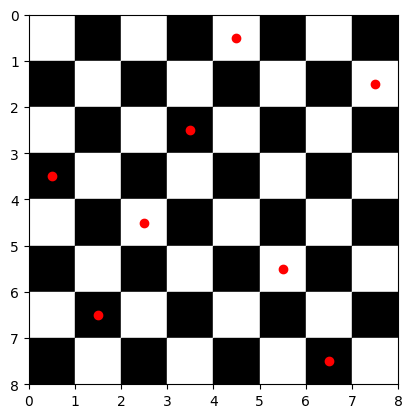

--- Окончательное решение ---
Лучшее решение: [(0, 5), (1, 1), (3, 0), (5, 4), (7, 3), (6, 7), (4, 2), (2, 6)], Конфликты: 0.0


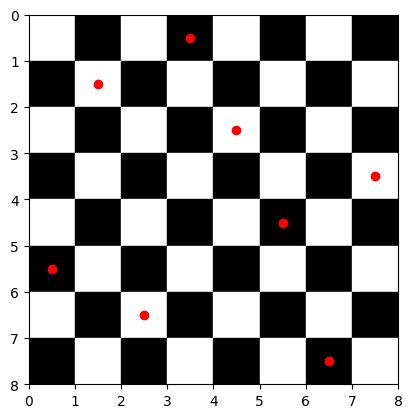

Веремя работы алгоритма: 10.910938358306884 с.
Кол-во итераций работы алгоритма: 531.9


In [125]:
times = []
epochs = []
for i in range(10):
  result, end_time, epoch = evolution_algo()
  times.append(end_time)
  epochs.append(epoch)
  draw_chessboard(result)

print(f"Веремя работы алгоритма: {np.mean(times)} с.")
print(f"Кол-во итераций работы алгоритма: {np.mean(epochs)}")

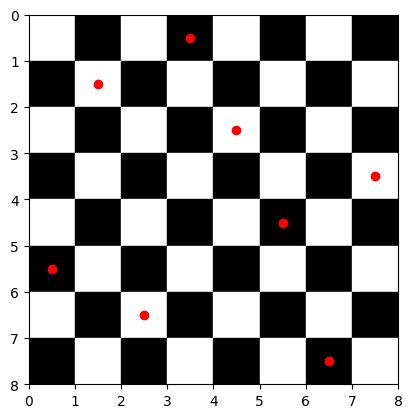

In [126]:
draw_chessboard(result)

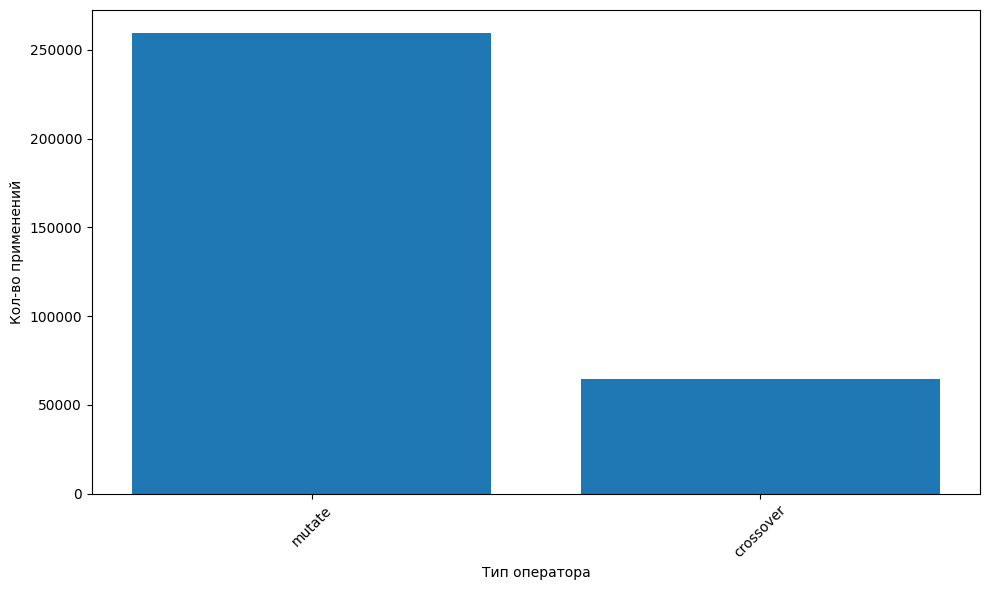

In [127]:
plot_bar_chart(GA_UASGE)

# Результаты запусков


| N | Popszie | Кол-во итераций сходимости | Время работы |
| - | ------- | -------------------------- | ------------ |
| 4 | 100     | 28.7 | 0.11|
| 4 | 300     | 15.7 | 0.19|
| 8 | 100     | 1541.4 | 9.85|
| 8 | 300     | 531.2 | 11.1|
| 10 | 100     | 13417.2 | 249.9|
| 10 | 300     | 10771.24 | 203.13|

# Ответы на вопросы

1. Задача расстановки N ферзей на шахматной доске размером NхN является комбинаторной задачей оптимизации. В задаче требуется найти оптимальное решение из конечного множества допустимых вариантов. В данной задаче оптимизация заключается в том, чтобы разместить ферзей на доске таким образом, чтобы они не находились под угрозой атаки друг друга. То есть, оптимальное решение предполагает нахождение расстановки ферзей, при которой не существует пары ферзей, которые могут атаковать друг друга по вертикалям, горизонталям или диагоналям.

2. Количество возможных комбинаций расстановки ферзей на доске экспоненциально возрастает с увеличением размерности N. Следовательно и растет сложность подбора решений